# Предсказание коэффициента восстановления золота из руды

# Этапы работы

[1. Подготовка данных](#step1)
- [знакомство с данными](#step1.1)
- [проверка расчета эффективности обогащения](#step1.2)
- [анализ признаков в тестовой выборке](#step1.3)
- [предобработка данных](#step1.4)

[2. Анализ данных](#step2)
- [концентрация металлов (Au, Ag, Pb) на различных этапах очистки](#step2.1)
- [распределения размеров гранул сырья на обучающей и тестовой выборках](#step2.2)
- [суммарная концентрация всех веществ на разных стадиях](#step2.3)

[3. Обучение и проверка моделей](#step3)
- [функция для вычисления итоговой sMAPE](#step3.1)
- [выбор лучшей модели и проверка на тестовой](#step3.2)

[4. Итоги проекта](#step4)

# Шаг 1. Подготовка данных <a id='step1'></a>

## Знакомство с данными <a id='step1.1'></a>

In [1]:
import pandas as pd

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats as st

from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

In [2]:
gold_recovery_train = pd.read_csv('/datasets/gold_recovery_train.csv') #обучающая выборка
gold_recovery_test = pd.read_csv('/datasets/gold_recovery_test.csv') #тестовая выборка
gold_recovery_full = pd.read_csv('/datasets/gold_recovery_full.csv') #общая выборка

In [3]:
gold_recovery_train.shape

(16860, 87)

In [4]:
gold_recovery_test.shape

(5856, 53)

In [5]:
gold_recovery_full.shape

(22716, 87)

Очень большая размерность таблиц. Попробуем для начала уменьшить объем данных, разобравшись, какие признаки на что влияют, избавившись от лишних столбцов. Посмотрим, какие признаки имеются:

In [6]:
gold_recovery_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22716 entries, 0 to 22715
Data columns (total 87 columns):
date                                                  22716 non-null object
final.output.concentrate_ag                           22627 non-null float64
final.output.concentrate_pb                           22629 non-null float64
final.output.concentrate_sol                          22331 non-null float64
final.output.concentrate_au                           22630 non-null float64
final.output.recovery                                 20753 non-null float64
final.output.tail_ag                                  22633 non-null float64
final.output.tail_pb                                  22516 non-null float64
final.output.tail_sol                                 22445 non-null float64
final.output.tail_au                                  22635 non-null float64
primary_cleaner.input.sulfate                         21107 non-null float64
primary_cleaner.input.depressant             

Например, в тестовой выборке столбцов меньше.  Отсутствуют расчетные столбцы с типом параметра **calculation** и столбцы, которые напрямую участвуют в расчете целевого признака. Во всех таблицах есть пропуски. 

## Проверка расчета эффективности обогащения <a id='step1.2'></a>

Рассчитаем **`rougher.output.recovery`** и сравним с фактическим. В рассчете будут участвовать **`rougher.input.feed_au`**, **`rougher.output.tail_au`**, **`rougher.output.concentrate_au`** - удалим в них пропуски, чтобы расчет получился корректным:

In [7]:
train_dublicate = gold_recovery_train.dropna(subset=['rougher.output.recovery','rougher.input.feed_au','rougher.output.tail_au','rougher.output.concentrate_au'])

In [8]:
train_dublicate[['rougher.output.recovery','rougher.input.feed_au','rougher.output.tail_au','rougher.output.concentrate_au']].head()

,rougher.output.recovery,rougher.input.feed_au,rougher.output.tail_au,rougher.output.concentrate_au
0,87.107763,6.486150,1.170244,19.793808
1,86.843261,6.478583,1.184827,20.050975
2,86.842308,6.362222,1.162562,19.737170
3,87.226430,6.118189,1.079755,19.320810
4,86.688794,5.663707,1.012642,19.216101


Для сравнения посчитаем среднее абсолютное отклонение:

In [9]:
c=train_dublicate['rougher.output.concentrate_au']
f=train_dublicate['rougher.input.feed_au']
t=train_dublicate['rougher.output.tail_au']
recovery=c*(f-t)/(f*(c-t))*100
mae = mean_absolute_error(train_dublicate['rougher.output.recovery'], recovery)
mae

9.444891926100695e-15

Получили почти 0. Следовательно значения в столбце **`rougher.output.recovery`** рассчитаны верно.

## Анализ признаков, которые отсутствуют в тестовой выборке <a id='step1.3'></a>

Как мы отметили выше, в тестовой выборке признаков меньше, пропусков почти нет. Проанализируем столбцы, которых нет в тестовой выборке:

In [10]:
difference = gold_recovery_train.drop(gold_recovery_test.columns, axis = 1)
difference.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16860 entries, 0 to 16859
Data columns (total 34 columns):
final.output.concentrate_ag                           16788 non-null float64
final.output.concentrate_pb                           16788 non-null float64
final.output.concentrate_sol                          16490 non-null float64
final.output.concentrate_au                           16789 non-null float64
final.output.recovery                                 15339 non-null float64
final.output.tail_ag                                  16794 non-null float64
final.output.tail_pb                                  16677 non-null float64
final.output.tail_sol                                 16715 non-null float64
final.output.tail_au                                  16794 non-null float64
primary_cleaner.output.concentrate_ag                 16778 non-null float64
primary_cleaner.output.concentrate_pb                 16502 non-null float64
primary_cleaner.output.concentrate_sol      

Это расчетные характеристики **calculation** и выходные данные, которые напрямую участвую в расчете коэффициента обогащения, который мы будем предсказывать.

В обучающей выборке можно точно оставить для начала только эти признаки. А дальше проанализируем их на выбросы, мультиколлинеарность, возможно увидим, что можно еще уменьшить количество признаков.

## Предобработка данных <a id='step1.4'></a>

Поэтому предлагаю, сначал попробовать отобрать наиболее значимые признаки, например отфильтровав коррелированные между собой. А потом уже удалить пропуски, чтобы не удалить лишнего.

Для начала проверим признаки на мультиколлинеарность, так как признаков очень много, даже в тестовой выборке, то сразу всю матрицу коррелляции выводить не будем, поделим на группы с одинаковыми этапами (коррреляцию признаков проверим на полных данных):

In [11]:
def corrspearman(data):
    parameters = data
    plt.figure(figsize = (20,20))
    corr=parameters.corr(method='spearman')
    corr[abs(corr)>0.7]
    sns.heatmap(corr[abs(corr)>0.7],annot=True, fmt=".2f")

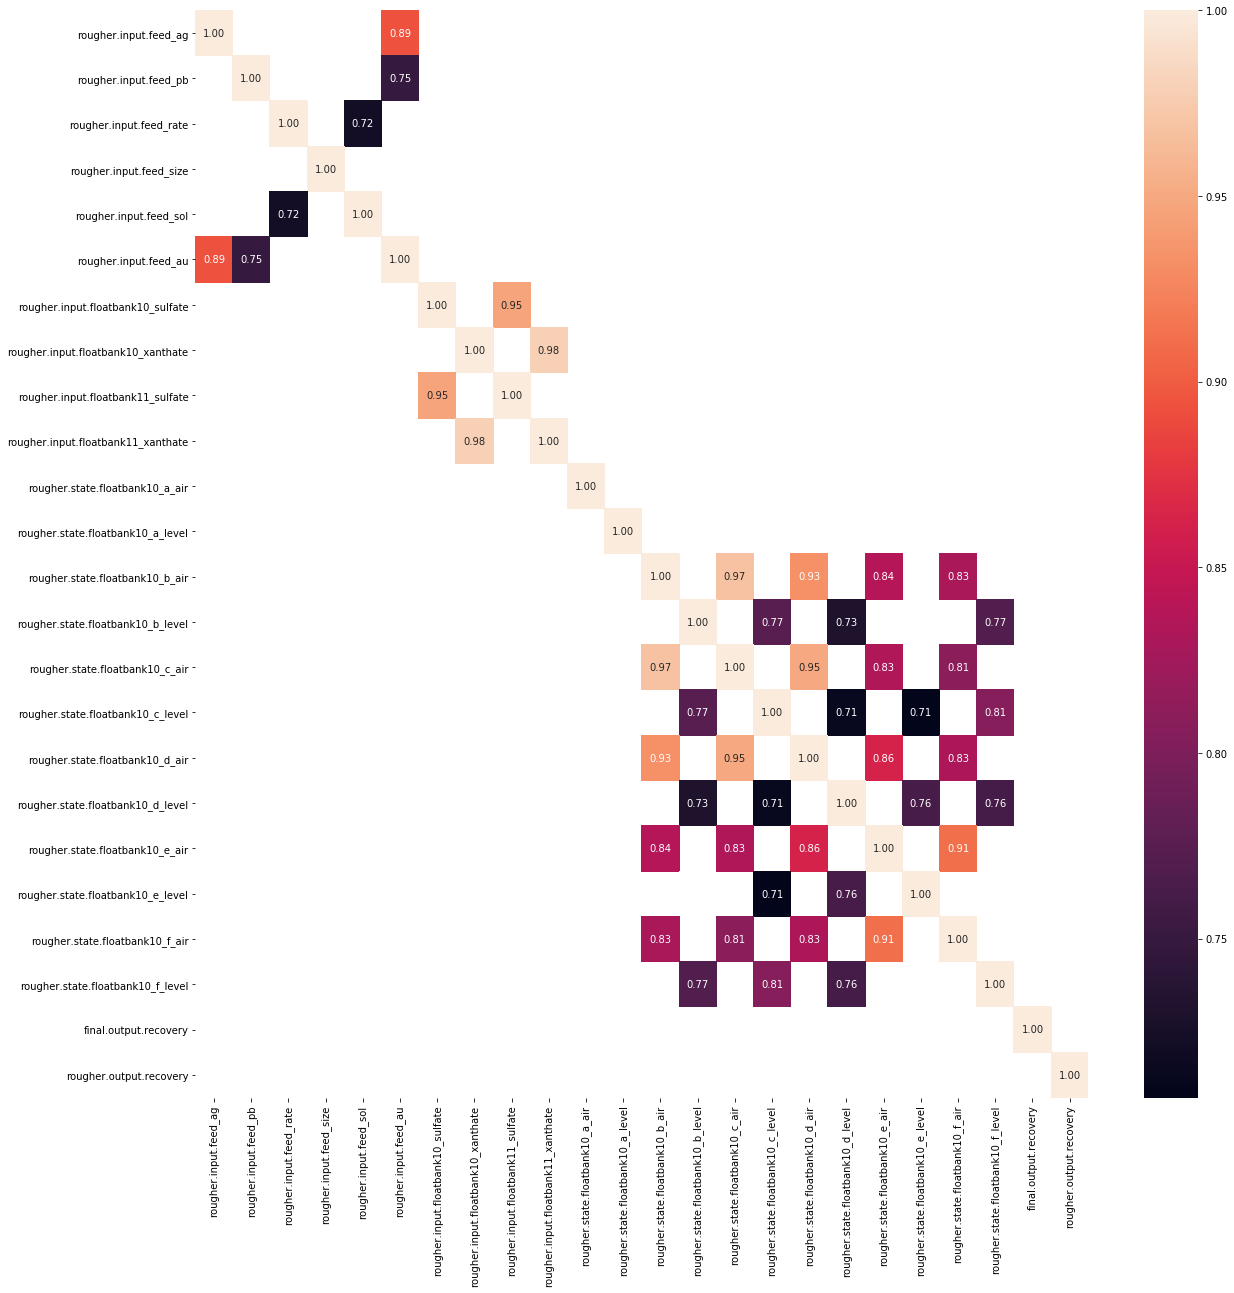

In [12]:
select = (gold_recovery_full[['rougher.input.feed_ag',
                              'rougher.input.feed_pb',
                              'rougher.input.feed_rate',
                              'rougher.input.feed_size',
                              'rougher.input.feed_sol',
                              'rougher.input.feed_au',
                              'rougher.input.floatbank10_sulfate',
                              'rougher.input.floatbank10_xanthate',
                              'rougher.input.floatbank11_sulfate',
                              'rougher.input.floatbank11_xanthate',
                              'rougher.state.floatbank10_a_air',
                              'rougher.state.floatbank10_a_level', 
                              'rougher.state.floatbank10_b_air',
                              'rougher.state.floatbank10_b_level',
                              'rougher.state.floatbank10_c_air',
                              'rougher.state.floatbank10_c_level',
                              'rougher.state.floatbank10_d_air',
                              'rougher.state.floatbank10_d_level',
                              'rougher.state.floatbank10_e_air',
                              'rougher.state.floatbank10_e_level',
                              'rougher.state.floatbank10_f_air',
                              'rougher.state.floatbank10_f_level',
                              'final.output.recovery',
                              'rougher.output.recovery']])
corrspearman(select)

Картинка выше не особо читаемая, но она как мозаика, на которую нужно смотреть издалека - четко видна картинка (более светлый квадрат), что показатели объема воздуха и уровня жидкости сильно коррелируются между собой, кроме одного (и почти не коррелируются с целевыми показателями). Также сильная корреляция между rougher.input.floatbank10_sulfate и rougher.input.floatbank11_sulfate, rougher.input.floatbank10_xanthate и rougher.input.floatbank11_xanthate.

Также сильная коррелляция между концентрацией разных металлов.

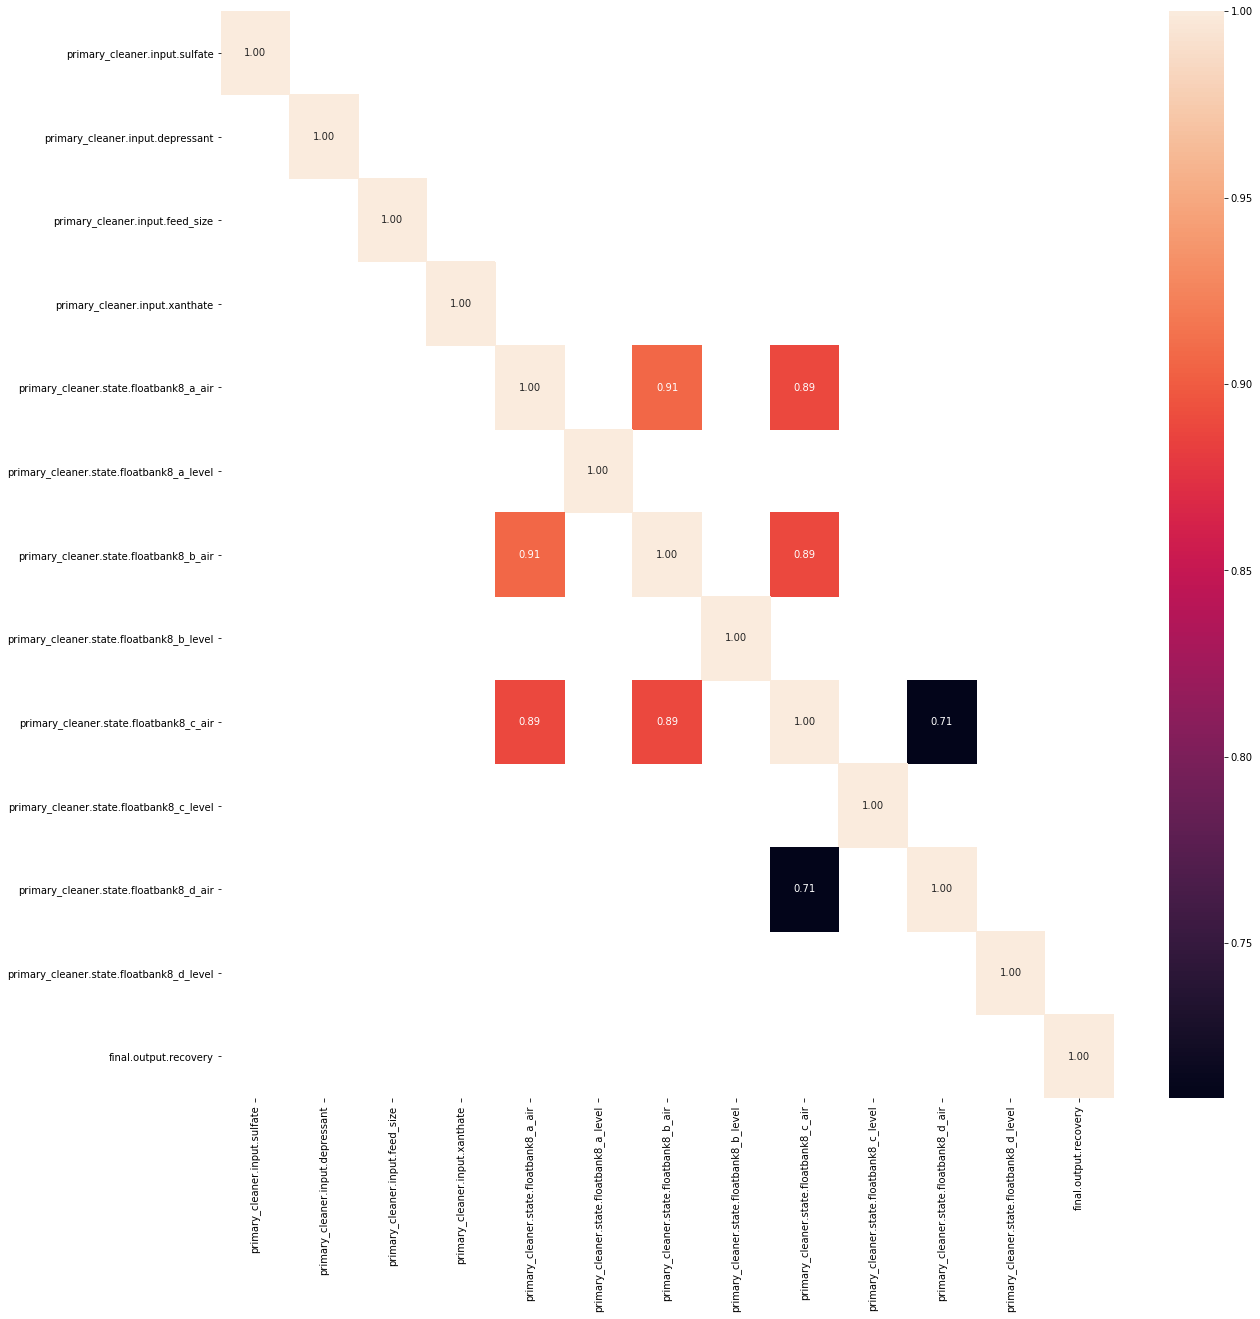

In [13]:
select = (gold_recovery_full[['primary_cleaner.input.sulfate',
                              'primary_cleaner.input.depressant', 
                              'primary_cleaner.input.feed_size',
                              'primary_cleaner.input.xanthate',
                              'primary_cleaner.state.floatbank8_a_air',
                              'primary_cleaner.state.floatbank8_a_level',
                              'primary_cleaner.state.floatbank8_b_air',
                              'primary_cleaner.state.floatbank8_b_level',
                              'primary_cleaner.state.floatbank8_c_air',
                              'primary_cleaner.state.floatbank8_c_level',
                              'primary_cleaner.state.floatbank8_d_air',
                              'primary_cleaner.state.floatbank8_d_level', 
                              'final.output.recovery']])
corrspearman(select)

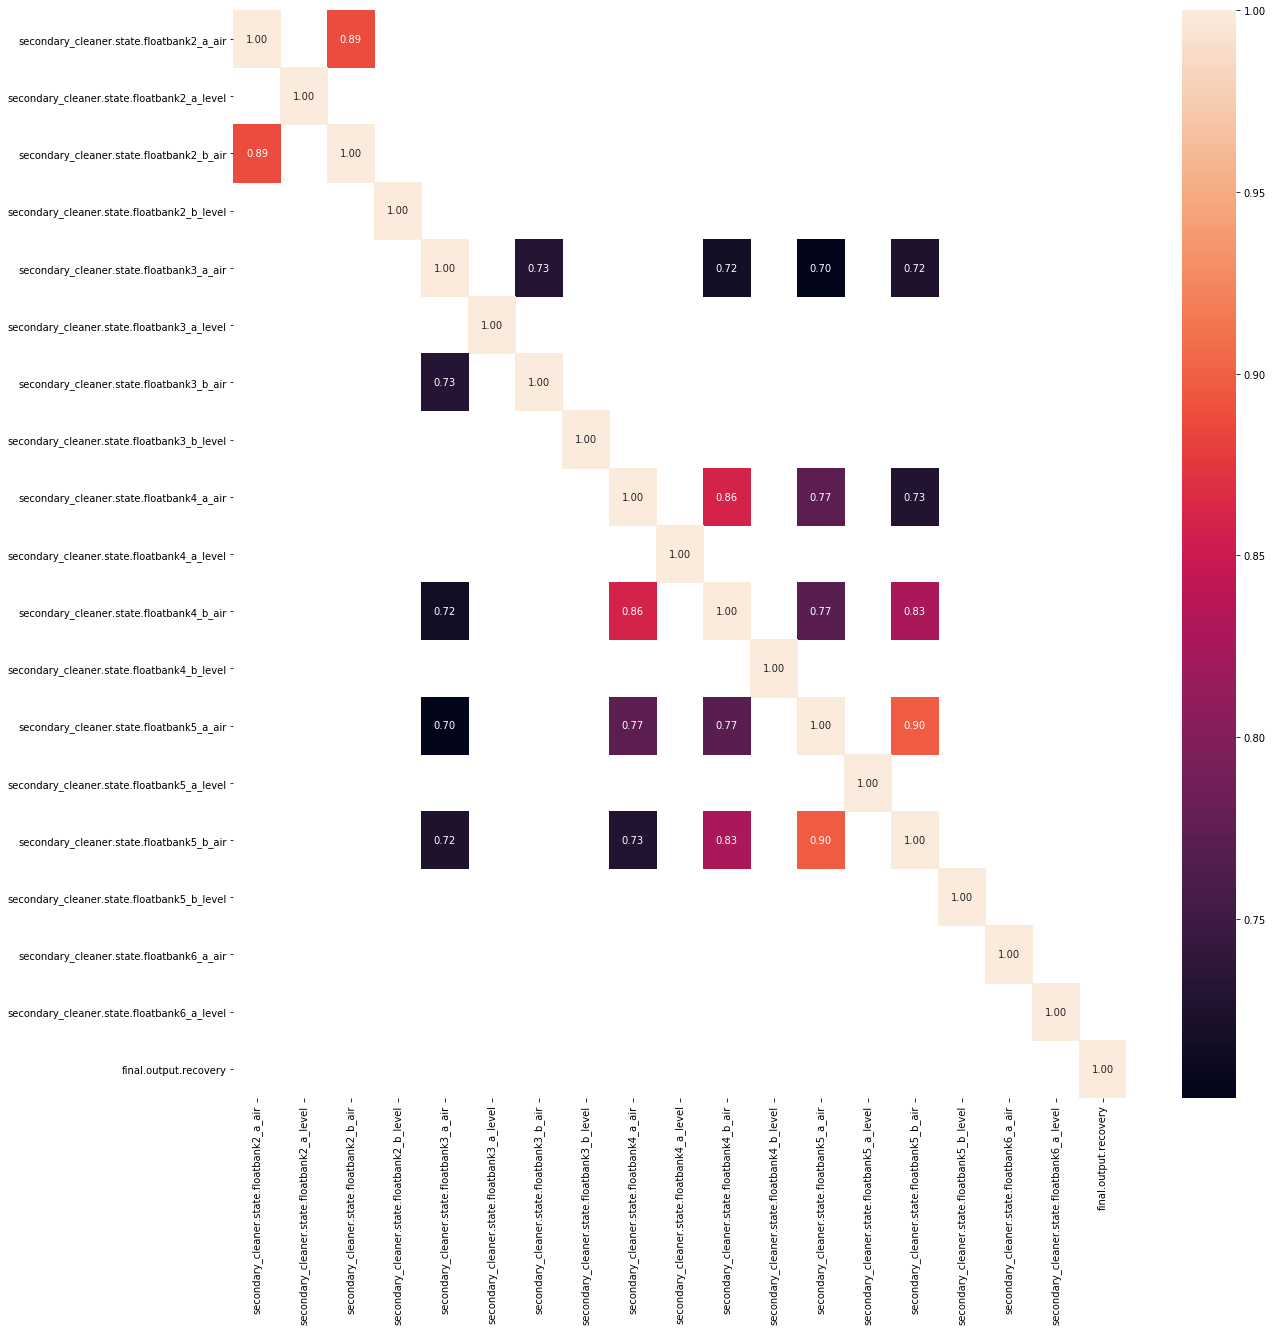

In [14]:
select = (gold_recovery_full[['secondary_cleaner.state.floatbank2_a_air',
                              'secondary_cleaner.state.floatbank2_a_level',
                              'secondary_cleaner.state.floatbank2_b_air',
                              'secondary_cleaner.state.floatbank2_b_level',
                              'secondary_cleaner.state.floatbank3_a_air',
                              'secondary_cleaner.state.floatbank3_a_level',
                              'secondary_cleaner.state.floatbank3_b_air',
                              'secondary_cleaner.state.floatbank3_b_level',
                              'secondary_cleaner.state.floatbank4_a_air',
                              'secondary_cleaner.state.floatbank4_a_level',
                              'secondary_cleaner.state.floatbank4_b_air',
                              'secondary_cleaner.state.floatbank4_b_level',
                              'secondary_cleaner.state.floatbank5_a_air',
                              'secondary_cleaner.state.floatbank5_a_level',
                              'secondary_cleaner.state.floatbank5_b_air',
                              'secondary_cleaner.state.floatbank5_b_level',
                              'secondary_cleaner.state.floatbank6_a_air',
                              'secondary_cleaner.state.floatbank6_a_level',
                              'final.output.recovery']])
corrspearman(select)

Аналогично на этапах очистки 1 и 2 видна сильная корреляция между объемами воздуха и жидкости на разных установках. Удалим их. В оставшихся признаках заполним пропуски и проверим на выбросы. 

Наверняка есть более продвинутые методы подбора признаков, но мы пока с ними не знакомы. Я читала про методы отобора признаков из библиотеки **mlxtend.feature_selection**. Но пока недостаточно хорошо их изучила и поняла, чтобы применить на практике.

# Шаг 2. Анализ данных <a id='step2'></a>

## концентрация металлов (Au, Ag, Pb) на различных этапах очистки <a id='step2.1'></a>

Концентрация металлов в исходном сырье содержится в признаках:
- rougher.input.feed_au
- rougher.input.feed_ag
- rougher.input.feed_pb

Концентрация металлов после этапа флотации:
- rougher.output.concentrate_au
- rougher.output.concentrate_ag
- rougher.output.concentrate_pb

Концентрация металлов после первого этапа очистки:
- primary_cleaner.output.concentrate_au
- primary_cleaner.output.concentrate_ag
- primary_cleaner.output.concentrate_pb

Концентрация металлов после второго этапа очистки:
- final.output.concentrate_au
- final.output.concentrate_ag
- final.output.concentrate_pb

Посмотрим концентрацию металлов на разных этапах:

In [15]:
concentrate_au = (gold_recovery_full[['rougher.input.feed_au',
                                      'rougher.output.concentrate_au',
                                      'primary_cleaner.output.concentrate_au',
                                      'final.output.concentrate_au']])
concentrate_ag = (gold_recovery_full[['rougher.input.feed_ag',
                                      'rougher.output.concentrate_ag',
                                      'primary_cleaner.output.concentrate_ag',
                                      'final.output.concentrate_ag']])
concentrate_pb = (gold_recovery_full[['rougher.input.feed_pb',
                                      'rougher.output.concentrate_pb',
                                      'primary_cleaner.output.concentrate_pb',
                                      'final.output.concentrate_pb']])

In [16]:
def comp_of_corr(data):
    columns = data.columns
    ax = data[columns[0]].plot(kind='hist', histtype='step', bins=25, linewidth=5, alpha=0.7, label='feed',legend=True, title='Концентрация металла на разных этапах', figsize=(10, 5))
    data[columns[1]].plot(kind='hist', histtype='step', bins=25, linewidth=5, alpha=0.7, label='rougher', ax=ax, grid=True, legend=True)
    data[columns[2]].plot(kind='hist', histtype='step', bins=25, linewidth=5, alpha=0.7, label='primary_cleaner', ax=ax, grid=True, legend=True)
    data[columns[3]].plot(kind='hist', histtype='step', bins=25, linewidth=5, alpha=0.7, label='final', ax=ax, grid=True, legend=True)

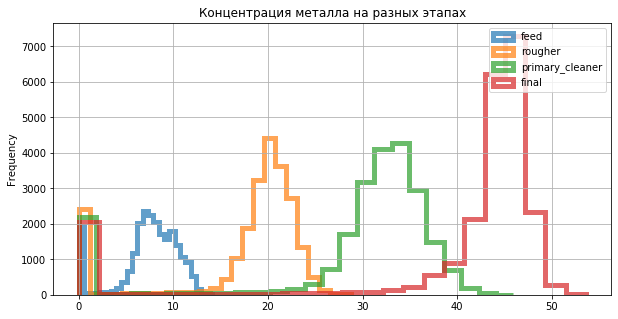

In [17]:
comp_of_corr(concentrate_au)

In [18]:
concentrate_au.describe()

,rougher.input.feed_au,rougher.output.concentrate_au,primary_cleaner.output.concentrate_au,final.output.concentrate_au
count,22617.000000,22618.000000,22618.000000,22630.000000
mean,7.565838,17.879538,29.212289,40.001172
std,3.026954,6.790112,10.539303,13.398062
min,0.000000,0.000000,0.000000,0.000000
25%,6.485009,17.928729,29.374406,42.383721
50%,7.884832,20.003202,32.359813,44.653436
75%,9.668064,21.564238,34.770726,46.111999
max,14.093363,28.824507,45.933934,53.611374


После каждого этапа концентрация золота растет. Также на каждом этапе есть большое количество нулевых значений. Это похоже на аномалии. Если изначально концентрация золота в исходном сырье была нулевой, то и на выходе будет 0, такие аномалии возможно нужно удалить.

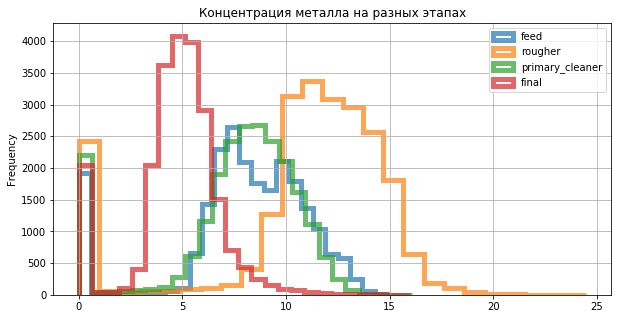

In [19]:
comp_of_corr(concentrate_ag)

In [20]:
concentrate_au.describe()

,rougher.input.feed_au,rougher.output.concentrate_au,primary_cleaner.output.concentrate_au,final.output.concentrate_au
count,22617.000000,22618.000000,22618.000000,22630.000000
mean,7.565838,17.879538,29.212289,40.001172
std,3.026954,6.790112,10.539303,13.398062
min,0.000000,0.000000,0.000000,0.000000
25%,6.485009,17.928729,29.374406,42.383721
50%,7.884832,20.003202,32.359813,44.653436
75%,9.668064,21.564238,34.770726,46.111999
max,14.093363,28.824507,45.933934,53.611374


Концентрация серебра уменьшается, наверняка, в хвостах его становится больше. Тоже есть концентрации равные 0.

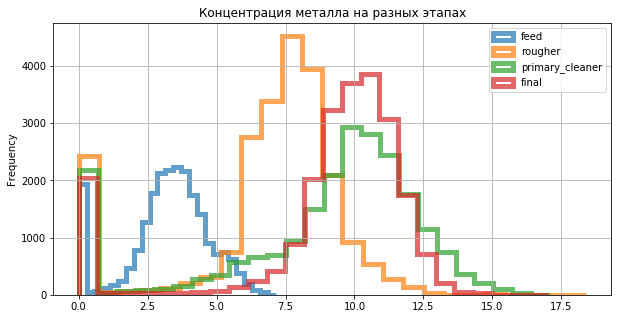

In [21]:
comp_of_corr(concentrate_pb)

In [22]:
concentrate_pb.describe()

,rougher.input.feed_pb,rougher.output.concentrate_pb,primary_cleaner.output.concentrate_pb,final.output.concentrate_pb
count,22472.000000,22618.000000,22268.000000,22629.000000
mean,3.305676,6.900646,8.921110,9.095308
std,1.446905,2.806948,3.706314,3.230797
min,0.000000,0.000000,0.000000,0.000000
25%,2.658814,6.374692,7.834690,8.750171
50%,3.432054,7.572855,9.921116,9.914519
75%,4.204960,8.477358,11.266100,10.929839
max,7.142594,18.394042,17.081278,17.031899


Концентрация свинца растет после флотации и первого этапа очистки, но не так интенсивно как золота. 

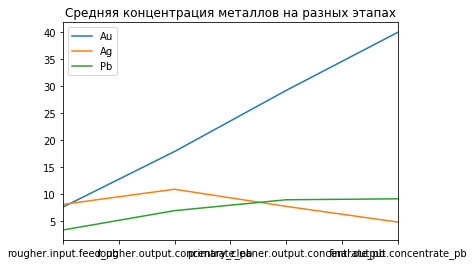

In [23]:
ax = concentrate_au.mean().plot(title='Средняя концентрация металлов на разных этапах', label='Au',legend=True)
concentrate_ag.mean().plot(ax=ax,label='Ag',legend=True)
concentrate_pb.mean().plot(ax=ax,label='Pb',legend=True)

Средняя концентрация золота растет после каждого этапа. Концентрация остальных металлов естесственно ниже, так как процессы настроены на получения концентрата золота.

## Распределения размеров гранул сырья на обучающей и тестовой выборках  <a id='step2.2'></a>

Размер гранул сырья - признак rougher.input.feed_size. Посмотрим плотности распределений размеров гранул сырья на тестовой и обучающей выборках:

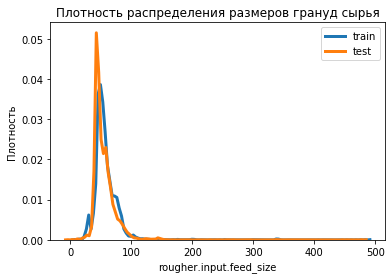

In [24]:
def distplot(data,label):
    sns.distplot(data['rougher.input.feed_size'], 
             hist = False, kde = True,
             kde_kws = {'linewidth': 3},
             label = label)
plt.title('Плотность распределения размеров грануд сырья')
plt.xlabel('Размер')
plt.ylabel('Плотность')

distplot(gold_recovery_train,'train')
distplot(gold_recovery_test,'test')

Визуально распределения похожи. И также наблюдается длинный хвост в обоих выборках - большие гранулы редки, похоже на выбросы.

## Суммарная концентрация всех веществ на разных стадиях  <a id='step2.3'></a>

Проверим на полных данных, потом если увидим аномалии удалим на train и test

In [25]:
concentrate_feed = (gold_recovery_full['rougher.input.feed_au']+
                    gold_recovery_full['rougher.input.feed_ag']+
                    gold_recovery_full['rougher.input.feed_pb']+
                    gold_recovery_full['rougher.input.feed_sol'])
concentrate_rougher = (gold_recovery_full['rougher.output.concentrate_au']+
                       gold_recovery_full['rougher.output.concentrate_ag']+
                       gold_recovery_full['rougher.output.concentrate_pb']+
                       gold_recovery_full['rougher.output.concentrate_sol'])
concentrate_primary_cleaner = (gold_recovery_full['primary_cleaner.output.concentrate_au']+
                               gold_recovery_full['primary_cleaner.output.concentrate_ag']+
                               gold_recovery_full['primary_cleaner.output.concentrate_pb']+
                               gold_recovery_full['primary_cleaner.output.concentrate_sol'])
concentrate_final = (gold_recovery_full['final.output.concentrate_au']+
                     gold_recovery_full['final.output.concentrate_ag']+
                     gold_recovery_full['final.output.concentrate_pb']+
                     gold_recovery_full['final.output.concentrate_pb'])

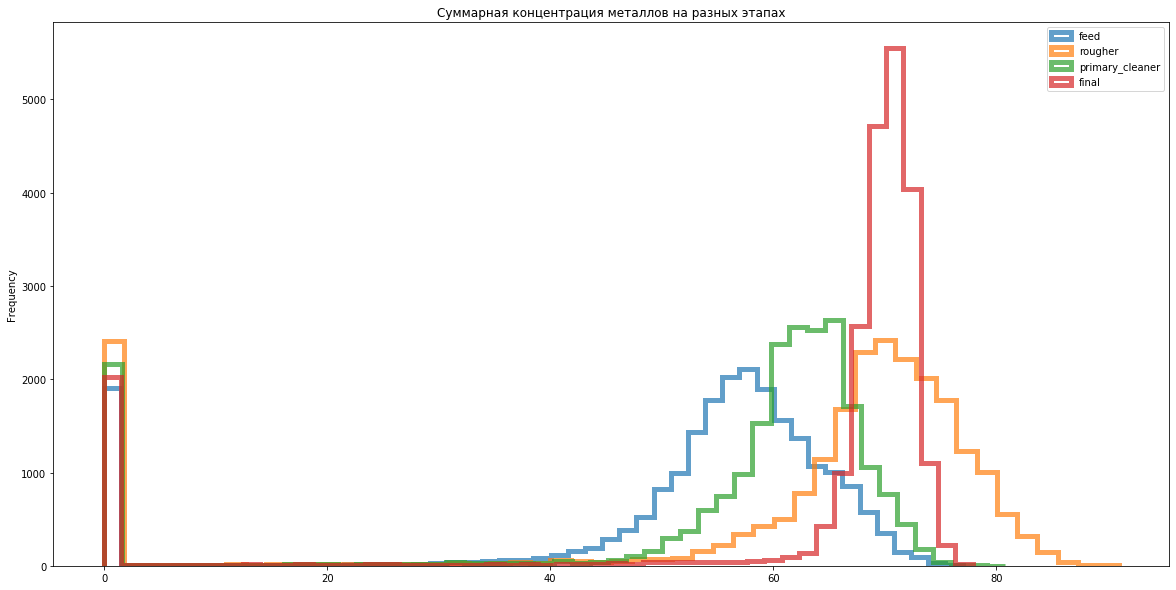

In [26]:
plt.figure(figsize = (20,10))
ax = concentrate_feed.plot(kind='hist', histtype='step',
                           bins=50, linewidth=5, alpha=0.7,
                           label='feed',legend=True, 
                           title='Суммарная концентрация металлов на разных этапах')
concentrate_rougher.plot(kind='hist', histtype='step', 
                         bins=50, linewidth=5, alpha=0.7,
                         label='rougher',legend=True, ax=ax)
concentrate_primary_cleaner.plot(kind='hist', histtype='step',
                                 bins=50, linewidth=5, alpha=0.7,
                                 label='primary_cleaner',legend=True, ax=ax)
concentrate_final.plot(kind='hist', histtype='step',
                       bins=50, linewidth=5, alpha=0.7, 
                       label='final',legend=True, ax=ax)


На любом этапе есть аномальные нулевые значений суммарной концентрации

Итак, подведем итог: попробуем оставить только часть признаков (убираем сильно коррелированные), удаляем строки с нулевой концентрацией металлов, избавляемся от выбросов на **`rougher.input.feed_size`**, если после этого останутся пропуски в оставшихся признаках в train и test - удалим их. И подтянем target в test.

Оставляем признаки: 

- primary_cleaner.input.sulfate               
- primary_cleaner.input.depressant
- rougher.input.feed_rate
- primary_cleaner.input.feed_size               
- primary_cleaner.input.xanthate                
- primary_cleaner.state.floatbank8_a_air        
- primary_cleaner.state.floatbank8_a_level      
- rougher.input.feed_rate                       
- rougher.input.feed_size                       
- rougher.input.feed_sol                        
- rougher.input.feed_au                         
- rougher.input.floatbank10_sulfate             
- rougher.input.floatbank10_xanthate            
- rougher.state.floatbank10_a_air               
- rougher.state.floatbank10_a_level             
- secondary_cleaner.state.floatbank2_a_air      
- secondary_cleaner.state.floatbank2_a_level

Целевые признаки:
- rougher.output.recovery
- final.output.recovery

In [27]:
columns = (['primary_cleaner.input.sulfate',
            'primary_cleaner.input.depressant', 
            'primary_cleaner.input.feed_size',
            'primary_cleaner.input.xanthate',
            'primary_cleaner.state.floatbank8_a_level',
            'primary_cleaner.state.floatbank8_b_level',
            'primary_cleaner.state.floatbank8_c_air',
            'primary_cleaner.state.floatbank8_c_level',
            'primary_cleaner.state.floatbank8_d_level', 
            'rougher.input.feed_rate',
            'rougher.input.feed_size', 
            'rougher.input.feed_au', 
            'rougher.input.floatbank10_sulfate',
            'rougher.input.floatbank10_xanthate',
            'rougher.state.floatbank10_a_air',
            'rougher.state.floatbank10_a_level', 
            'rougher.state.floatbank10_c_air',
            'rougher.state.floatbank10_c_level',
            'secondary_cleaner.state.floatbank2_a_air',
            'secondary_cleaner.state.floatbank2_a_level',
            'secondary_cleaner.state.floatbank2_b_level',
            'secondary_cleaner.state.floatbank3_a_air',
            'secondary_cleaner.state.floatbank3_a_level',
            'secondary_cleaner.state.floatbank3_b_level',
            'secondary_cleaner.state.floatbank4_a_air',
            'secondary_cleaner.state.floatbank4_a_level',
            'secondary_cleaner.state.floatbank4_b_level',
            'secondary_cleaner.state.floatbank5_a_level',
            'secondary_cleaner.state.floatbank5_b_level',
            'secondary_cleaner.state.floatbank6_a_air',
            'secondary_cleaner.state.floatbank6_a_level',
            'rougher.output.recovery',
            'final.output.recovery'])

In [28]:
gold_recovery_train_select = gold_recovery_train[columns]
gold_recovery_train_select.shape

(16860, 33)

Убираем нулевую и **`околонулевую`** концентрацию золота в сырье

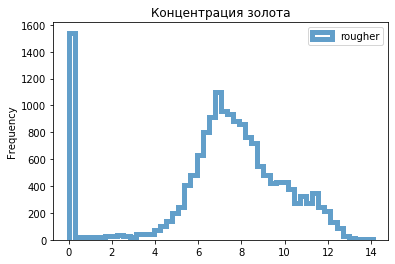

In [29]:
#было
ax=gold_recovery_train_select['rougher.input.feed_au'].plot(kind='hist', histtype='step', 
                         bins=50, linewidth=5, alpha=0.7,
                         label='rougher',legend=True,title='Концентрация золота')

In [30]:
gold_recovery_train_select = gold_recovery_train_select.loc[gold_recovery_train_select['rougher.input.feed_au'] > 2]
gold_recovery_train_select.shape

(15101, 33)

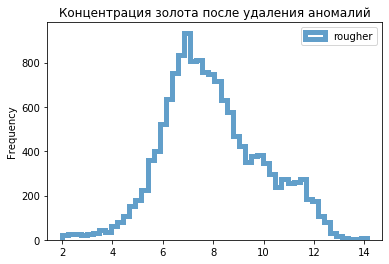

In [31]:
#стало:
ax=gold_recovery_train_select['rougher.input.feed_au'].plot(kind='hist', histtype='step', 
                         bins=50, linewidth=5, alpha=0.7,
                         label='rougher',legend=True, title='Концентрация золота после удаления аномалий')

Удаляем выбросы в размерах гранул:

In [32]:
quan = gold_recovery_full['rougher.input.feed_size'].quantile(0.99)
gold_recovery_train_select = gold_recovery_train_select.loc[gold_recovery_train_select['rougher.input.feed_size']<quan]

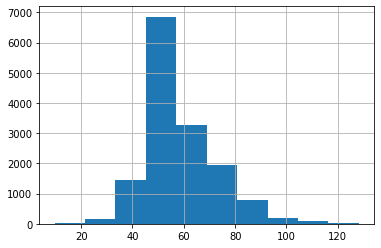

In [33]:
gold_recovery_train_select['rougher.input.feed_size'].hist()

Удаляем оставшиеся пропуски

In [34]:
gold_recovery_train_select = gold_recovery_train_select.dropna(
    subset = ['rougher.output.recovery','final.output.recovery'])

In [35]:
gold_recovery_train_select = gold_recovery_train_select.fillna(method='ffill')
gold_recovery_train_select.shape

(13805, 33)

Аналогичные операции сделаем с test, дополнительно подтянув из full таргеты:

In [36]:
#исходный
gold_recovery_test.shape

(5856, 53)

In [37]:
#добавляем таргеты
gold_recovery_test = gold_recovery_test.merge(gold_recovery_full[['date','rougher.output.recovery','final.output.recovery']],on=['date'])
gold_recovery_test.shape

(5856, 55)

Оставляем нужные столбцы:

In [38]:
gold_recovery_test_select = gold_recovery_test[columns]
gold_recovery_test_select.shape

(5856, 33)

Убираем околонулевую концентрацию:

In [39]:
gold_recovery_test_select = gold_recovery_test_select.loc[gold_recovery_test_select['rougher.input.feed_au'] > 2]
gold_recovery_test_select.shape

(5455, 33)

Удаляем выбросы в размерах гранул:

In [40]:
gold_recovery_test_select = gold_recovery_test_select.loc[gold_recovery_test_select['rougher.input.feed_size']<quan]
gold_recovery_test_select.shape

(5398, 33)

#Убираем оставшиеся пропуски:
Исправление ЗАПОЛНЯЕМ, а не удаляем:

In [41]:
gold_recovery_test_select = gold_recovery_test_select.dropna(
    subset = ['rougher.output.recovery','final.output.recovery'])

In [42]:
gold_recovery_test_select = gold_recovery_test_select.fillna(method='ffill')
gold_recovery_test_select.shape

(5251, 33)

Поделим выборки на feature и target: rougher.output.recovery
final.output.recovery

In [43]:
gold_recovery_train_select_features = gold_recovery_train_select.drop(['rougher.output.recovery','final.output.recovery'], axis=1)
gold_recovery_train_select_target = gold_recovery_train_select[['rougher.output.recovery','final.output.recovery']]

In [44]:
gold_recovery_train_select_features.shape

(13805, 31)

In [45]:
gold_recovery_train_select_target.shape

(13805, 2)

In [46]:
gold_recovery_test_select_features = gold_recovery_test_select.drop(['rougher.output.recovery','final.output.recovery'], axis=1)
gold_recovery_test_select_target = gold_recovery_test_select[['rougher.output.recovery','final.output.recovery']]

In [47]:
gold_recovery_test_select_features.shape

(5251, 31)

In [48]:
gold_recovery_test_select_target.shape

(5251, 2)

# 3. Обучение и проверка моделей <a id='step3'></a>

## Функция для вычисления итоговой sMAPE <a id='step3.1'></a>

In [49]:
def smape(predict,target):
    rougher_target = pd.DataFrame(target).iloc[:,0]
    final_target = pd.DataFrame(target).iloc[:,1]
    rougher_predict = pd.DataFrame(predict).iloc[:,0]
    final_predict = pd.DataFrame(predict).iloc[:,1]
    rougher_smape = ((abs(rougher_target-rougher_predict))/((abs(rougher_target)+abs(rougher_predict))/2)).sum()/len(rougher_target)
    final_smape = ((abs(final_target-final_predict))/((abs(final_target)+abs(final_predict))/2)).sum()/len(rougher_target)
    return 0.25*rougher_smape+0.75*final_smape


## Выбор лучшей модели и проверка на тестовой <a id='step3.2'></a>

- **решающее дерево**

In [50]:
score_DecisionTree = pd.DataFrame(columns = ['depth', 'smape'])
i = 0
for depth in range(2, 10):
    model = DecisionTreeRegressor(random_state=12345, max_depth = depth)
    predictions = pd.DataFrame(cross_val_predict(model,gold_recovery_train_select_features, 
                                         gold_recovery_train_select_target,cv=5))
    #model.fit(gold_recovery_train_select_features, gold_recovery_train_select_target)
    #predictions = pd.DataFrame(model.predict(gold_recovery_test_select_features))
    score_DecisionTree.loc[i] = [depth, smape(predictions,gold_recovery_train_select_target)]
    i=i+1

score_DecisionTree

,depth,smape
0,2.0,0.098540
1,3.0,0.099000
2,4.0,0.098071
3,5.0,0.098800
4,6.0,0.113247
5,7.0,0.115566
6,8.0,0.120499
7,9.0,0.156036


Наилучший результат показала модель "дерево решений" с параметром max_depth=4 Проверим ее на тестовой выборке:

In [51]:
model = DecisionTreeRegressor(random_state=12345, max_depth = 4)
model.fit(gold_recovery_train_select_features, gold_recovery_train_select_target)
gold_recovery_test_select_predictions = model.predict(gold_recovery_test_select_features)
smape(pd.DataFrame(gold_recovery_test_select_predictions),gold_recovery_test_select_target)

0.0872778891538982

Проверка адеватности модели

In [52]:
rougher_predict = pd.Series(gold_recovery_train_select_target['rougher.output.recovery'].median(), index=gold_recovery_test_select_target.index)
final_predict = pd.Series(gold_recovery_train_select_target['final.output.recovery'].median(), index=gold_recovery_test_select_target.index)
rougher_target = gold_recovery_test_select_target['rougher.output.recovery']
final_target = gold_recovery_test_select_target['final.output.recovery']

In [53]:
rougher_smape = ((abs(rougher_target-rougher_predict))/((abs(rougher_target)+abs(rougher_predict))/2)).sum()/len(rougher_target)
final_smape = ((abs(final_target-final_predict))/((abs(final_target)+abs(final_predict))/2)).sum()/len(rougher_target)
0.25*rougher_smape+0.75*final_smape

0.0933098191889351

Наша модель немного выиграла у константной, но преимущество совсем небольшое.

# Итоги проекта <a id='step4'></a>

В данном проекте мы пытались предсказать коэффициент восстановления золота из золотосодержащей руды. Мы подготовили данные, провели исследовательский анализ, построили и обучили модели.
Лучший результат показала модель DecisionTreeRegressor с параметрами depth=4, наименьший результат метрики sMape этой модели 8,7%.